In [301]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import os
import matplotlib.pyplot as plt
from scipy import stats

In [302]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [303]:
BASE_PATH = '/content/drive/Shared drives/Citadel Datathon 2020 Summer/datasets'
UK_INFLATION_CSV = 'UK_inflation.csv'
UK_HOUSE_PRICE_CSV = 'London_house_transaction_price_per_sqm_with_ave_earning.csv'
UK_HOUSE_SALES_VOLUME_CSV = 'UK_house_sales_volume.csv'

# 1.Read Data

In [304]:
london_inflation = pd.read_csv(os.path.join(BASE_PATH, UK_INFLATION_CSV))

In [305]:
price = pd.read_csv(os.path.join(BASE_PATH, UK_HOUSE_PRICE_CSV))
vol = pd.read_csv(os.path.join(BASE_PATH, UK_HOUSE_SALES_VOLUME_CSV))

In [306]:
price

,Unnamed: 0,Unnamed: 0.1,Transaction_Unique_Identifier,Price,Date,Postcode,Property_Type,Old_New,Duration,Primary Address,Secondary Address,Street,Locality,City,District,County,PPD,Record_Status,Code,Name,Av floorspace of houses (m2),Av floorspace of flats (m2),Av floorspace of All properties (m2),Is_House,Is_Flat,Expected Floor Space,Price Per Squared Meter,year,pay,confidence
0,0,0,{FB04AF14-532E-44F4-BA5B-801A66EE2C8F},174000.0,2005-06-24,SE9 2JJ,S,N,F,130,NaN,RESTONS CRESCENT,LONDON,LONDON,GREENWICH,GREATER LONDON,A,A,E09000011,Greenwich,96.720395,63.277686,77.397582,1,0,96.720395,1799.000103,2005,192.112500,7.112500
1,1,1,{714E3BC5-4148-41FD-B840-71D7B744D200},235000.0,2005-05-17,SE13 5HX,F,N,F,39,NaN,LEAHURST ROAD,LONDON,LONDON,LEWISHAM,GREATER LONDON,A,A,E09000023,Lewisham,101.297810,60.780819,75.351529,0,1,60.780819,3866.351303,2005,195.250000,6.912500
2,2,2,{675FDF3D-952A-45D0-9567-71D7E240FBD7},249980.0,2005-04-21,SE19 2PU,T,N,F,9,NaN,SUMMIT WAY,LONDON,LONDON,CROYDON,GREATER LONDON,A,A,E09000008,Croydon,103.408678,57.008083,81.058041,1,0,103.408678,2417.398675,2005,193.552500,5.712500
3,3,3,{84C271E0-F4B1-4115-AD27-78F11904389A},320000.0,2005-05-13,SW19 3AX,T,N,F,39,NaN,BOSCOMBE ROAD,LONDON,LONDON,MERTON,GREATER LONDON,A,A,E09000024,Merton,110.056902,59.309793,86.356148,1,0,110.056902,2907.586853,2005,232.785714,7.457143
4,4,4,{7EE59E42-DB90-4085-B14C-78F2940DD13A},295000.0,2005-12-20,SW2 2DT,T,N,F,51,NaN,ATHLONE ROAD,LONDON,LONDON,LAMBETH,GREATER LONDON,A,A,E09000022,Lambeth,119.136295,62.619822,74.114746,1,0,119.136295,2476.155560,2005,204.187500,6.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317405,317405,331283,{965B6D91-E5A9-95E4-E053-6C04A8C07729},2100000.0,2019-10-03,SW19 8RB,S,N,F,60,NaN,PRINCES ROAD,NaN,LONDON,MERTON,GREATER LONDON,A,A,E09000024,Merton,110.056902,59.309793,86.356148,1,0,110.056902,19081.038724,2019,269.105000,7.400000
317406,317406,331284,{965B6D91-E5AC-95E4-E053-6C04A8C07729},464000.0,2019-09-17,SE25 6UB,T,N,F,29,NaN,NUGENT ROAD,NaN,LONDON,CROYDON,GREATER LONDON,A,A,E09000008,Croydon,103.408678,57.008083,81.058041,1,0,103.408678,4487.050904,2019,254.735000,4.800000
317407,317407,331285,{965B6D91-E5AE-95E4-E053-6C04A8C07729},1325000.0,2019-10-03,SW19 3QR,S,N,F,23,NaN,FAIRLAWN ROAD,WIMBLEDON,LONDON,MERTON,GREATER LONDON,A,A,E09000024,Merton,110.056902,59.309793,86.356148,1,0,110.056902,12039.226814,2019,269.105000,7.400000
317408,317408,331286,{965B6D91-E7D4-95E4-E053-6C04A8C07729},565000.0,2019-08-23,SW16 4UU,S,N,F,40,NaN,POLLARDS HILL EAST,NaN,LONDON,CROYDON,GREATER LONDON,A,A,E09000008,Croydon,103.408678,57.008083,81.058041,1,0,103.408678,5463.758106,2019,254.735000,4.800000


In [307]:
price['District'].unique().shape

(32,)

In [308]:
def cap(a):
  return a.capitalize()

In [309]:
price = price[['Date', 'District', 'Old_New', 'Is_House', 'Is_Flat', 'Price', 'pay', 'confidence']]
price = price.dropna()
price['District'] = price['District'].apply(cap)
price.head()

,Date,District,Old_New,Is_House,Is_Flat,Price,pay,confidence
0,2005-06-24,Greenwich,N,1,0,174000.0,192.112500,7.112500
1,2005-05-17,Lewisham,N,0,1,235000.0,195.250000,6.912500
2,2005-04-21,Croydon,N,1,0,249980.0,193.552500,5.712500
3,2005-05-13,Merton,N,1,0,320000.0,232.785714,7.457143
4,2005-12-20,Lambeth,N,1,0,295000.0,204.187500,6.400000


In [310]:
b = list(price['District'].unique())
b = [s.strip() for s in b]
b = [s.capitalize() for s in b]
b = set(b)

In [311]:
# a = set(['City of London', 'Barking & Dagenham', 'Barnet', 'Bexley', 'Brent',
#        'Bromley', 'Camden', 'Croydon', 'Ealing', 'Enfield', 'Greenwich',
#        'Hackney', 'Hammersmith & Fulham', 'Haringey', 'Harrow', "Havering",
#        'Hillingdon', 'Hounslow', 'Islington', 'Kensington & Chelsea',
#        'Kingston upon Thames', 'Lambeth', 'Lewisham', 'Merton', 'Newham',
#        'Redbridge', 'Richmond upon Thames', 'Southwark', 'Sutton',
#        'Tower Hamlets', 'Waltham Forest', 'Wandsworth', 'Westminster'])

# 2.Preprocessing

In [312]:
# set host and London boroughs
host_boroughs = ['Barking and dagenham', 'Greenwich', 'Hackney', 'Newham', 'Tower hamlets', 'Waltham forest']
central_host_boroughs = ['Brent', 'Westminster', 'Kensington and chelsea', 'Hammersmith and fulham', 'Wandsworth']
london_boroughs = list(b)

In [313]:
other_borough = []
for ele in london_boroughs:
   if ele not in central_host_boroughs and ele not in host_boroughs:
      other_borough.append(ele)
other_borough

['Merton',
 'Haringey',
 'Southwark',
 'Harrow',
 'Hillingdon',
 'Redbridge',
 'Barnet',
 'Richmond upon thames',
 'Ealing',
 'Hounslow',
 'Lewisham',
 'Croydon',
 'Bromley',
 'Enfield',
 'Bexley',
 'Kingston upon thames',
 'Camden',
 'City of london',
 'Islington',
 'Lambeth']

In [314]:
UK_HOUSE_PRICE_CSV1 = 'UK_house_price.csv'
price_old = pd.read_csv(os.path.join(BASE_PATH, UK_HOUSE_PRICE_CSV1))
price_old.index = pd.to_datetime(price_old['Unnamed: 0'])
price_old = price_old .drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 34',  'Unnamed: 37',  'Unnamed: 47'])
price_old.columns = ['City of London', 'Barking and dagenham', 'Barnet', 'Bexley', 'Brent',
       'Bromley', 'Camden', 'Croydon', 'Ealing', 'Enfield', 'Greenwich',
       'Hackney', 'Hammersmith and fulham', 'Haringey', 'Harrow', 'Havering',
       'Hillingdon', 'Hounslow', 'Islington', 'Kensington and chelsea',
       'Kingston upon thames', 'Lambeth', 'Lewisham', 'Merton', 'Newham',
       'Redbridge', 'Richmond upon thames', 'Southwark', 'Sutton',
       'Tower Hamlets', 'Waltham Forest', 'Wandsworth', 'Westminster',
       'Inner London', 'Outer London', 'NORTH EAST', 'NORTH WEST',
       'YORKS & THE HUMBER', 'EAST MIDLANDS', 'WEST MIDLANDS',
       'EAST OF ENGLAND', 'LONDON', 'SOUTH EAST', 'SOUTH WEST', 'England']
crisis_multiplier = pd.DataFrame(price_old.loc["2008-06-01",] / price_old.loc["2009-04-01",])
crisis_multiplier = crisis_multiplier.reset_index()
crisis_multiplier.columns=['area', 'crisis_multiplier']
crisis_multiplier.head()

,area,crisis_multiplier
0,City of London,1.218124
1,Barking and dagenham,1.253056
2,Barnet,1.189196
3,Bexley,1.170539
4,Brent,1.102469


In [315]:
# change price shape
price_unstack = price

price_unstack.columns = ["date",	"area",	"Old_New",	"Is_House",	"Is_Flat",	"Price Per Squared Meter",	"pay",	"confidence"]
price_unstack['date'] = pd.to_datetime(price_unstack['date'])
# crisis adjustment
price_unstack = price_unstack.merge(crisis_multiplier, on="area", how="left")
price_unstack.loc[price_unstack['date']<pd.to_datetime("2008-07-01"), 'crisis_multiplier'] = 1
price_unstack = price_unstack[price_unstack['area'].isin(london_boroughs)]
price_unstack = price_unstack.reset_index()
price_unstack

,index,date,area,Old_New,Is_House,Is_Flat,Price Per Squared Meter,pay,confidence,crisis_multiplier
0,0,2005-06-24,Greenwich,N,1,0,174000.0,192.112500,7.112500,1.000000
1,1,2005-05-17,Lewisham,N,0,1,235000.0,195.250000,6.912500,1.000000
2,2,2005-04-21,Croydon,N,1,0,249980.0,193.552500,5.712500,1.000000
3,3,2005-05-13,Merton,N,1,0,320000.0,232.785714,7.457143,1.000000
4,4,2005-12-20,Lambeth,N,1,0,295000.0,204.187500,6.400000,1.000000
...,...,...,...,...,...,...,...,...,...,...
312298,312298,2019-10-03,Merton,N,1,0,2100000.0,269.105000,7.400000,1.187778
312299,312299,2019-09-17,Croydon,N,1,0,464000.0,254.735000,4.800000,1.183547
312300,312300,2019-10-03,Merton,N,1,0,1325000.0,269.105000,7.400000,1.187778
312301,312301,2019-08-23,Croydon,N,1,0,565000.0,254.735000,4.800000,1.183547


In [316]:
price_unstack['date'].max()

Timestamp('2019-11-29 00:00:00')

In [317]:
def before_after(x):
    """determine if before or after announce"""
    if x < pd.to_datetime('2005-07-06'):
        return 0
    return 1
def before_after_construct(x):
    """determine if before or after announce"""
    if x < pd.to_datetime('2007-07-01'):
        return 0
    return 1
def is_new(x):
    if x == "N":
        return 1
    else:
        return 0

In [318]:
price_unstack = price_unstack[price_unstack['date']<pd.to_datetime("2017-01-01")]

#### Dataset inside London

In [319]:
# add dummy variables: time
price_unstack['before_after'] = price_unstack['date'].apply(before_after_construct)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [320]:
# is new
price_unstack['is_new'] = price_unstack['Old_New'].apply(is_new)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [321]:
# days to start constructing
price_unstack['to_construct'] = pd.to_datetime(price_unstack['date']).sub(pd.Timestamp('2007-07-01')).dt.days

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [322]:
price_unstack

,index,date,area,Old_New,Is_House,Is_Flat,Price Per Squared Meter,pay,confidence,crisis_multiplier,before_after,is_new,to_construct
0,0,2005-06-24,Greenwich,N,1,0,174000.0,192.112500,7.112500,1.000000,0,1,-737
1,1,2005-05-17,Lewisham,N,0,1,235000.0,195.250000,6.912500,1.000000,0,1,-775
2,2,2005-04-21,Croydon,N,1,0,249980.0,193.552500,5.712500,1.000000,0,1,-801
3,3,2005-05-13,Merton,N,1,0,320000.0,232.785714,7.457143,1.000000,0,1,-779
4,4,2005-12-20,Lambeth,N,1,0,295000.0,204.187500,6.400000,1.000000,0,1,-558
...,...,...,...,...,...,...,...,...,...,...,...,...,...
267687,267687,2016-09-16,Lewisham,N,1,0,610000.0,240.545000,6.012500,1.104704,1,1,3365
267688,267688,2016-09-29,Greenwich,N,1,0,583000.0,236.168750,6.162500,1.173609,1,1,3378
267689,267689,2016-10-11,Lewisham,N,1,0,425000.0,240.545000,6.012500,1.104704,1,1,3390
267690,267690,2016-10-14,Greenwich,N,1,0,300000.0,236.168750,6.162500,1.173609,1,1,3393


In [323]:
# multiply by inflation
price_unstack['year'] = price_unstack['date'].dt.year
price_unstack = price_unstack.merge(london_inflation[['year', 'multiplier']], on='year', how='left')
price_unstack.dropna(inplace=True)
price_unstack['price_inflated'] = price_unstack['Price Per Squared Meter'] * price_unstack['multiplier']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [324]:
# crisis multiplier
price_unstack['price_inflated'] = price_unstack['price_inflated']*price_unstack['crisis_multiplier']
price_unstack

,index,date,area,Old_New,Is_House,Is_Flat,Price Per Squared Meter,pay,confidence,crisis_multiplier,before_after,is_new,to_construct,year,multiplier,price_inflated
0,0,2005-06-24,Greenwich,N,1,0,174000.0,192.112500,7.112500,1.000000,0,1,-737,2005,1.46,254040.000000
1,1,2005-05-17,Lewisham,N,0,1,235000.0,195.250000,6.912500,1.000000,0,1,-775,2005,1.46,343100.000000
2,2,2005-04-21,Croydon,N,1,0,249980.0,193.552500,5.712500,1.000000,0,1,-801,2005,1.46,364970.800000
3,3,2005-05-13,Merton,N,1,0,320000.0,232.785714,7.457143,1.000000,0,1,-779,2005,1.46,467200.000000
4,4,2005-12-20,Lambeth,N,1,0,295000.0,204.187500,6.400000,1.000000,0,1,-558,2005,1.46,430700.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267687,267687,2016-09-16,Lewisham,N,1,0,610000.0,240.545000,6.012500,1.104704,1,1,3365,2016,1.05,707562.600547
267688,267688,2016-09-29,Greenwich,N,1,0,583000.0,236.168750,6.162500,1.173609,1,1,3378,2016,1.05,718424.622973
267689,267689,2016-10-11,Lewisham,N,1,0,425000.0,240.545000,6.012500,1.104704,1,1,3390,2016,1.05,492973.943004
267690,267690,2016-10-14,Greenwich,N,1,0,300000.0,236.168750,6.162500,1.173609,1,1,3393,2016,1.05,369686.769969


In [325]:
# add time period stamps
price_unstack['River'] = (price_unstack['area'].isin(host_boroughs)) * 1
price_unstack['Central'] = (price_unstack['area'].isin(central_host_boroughs)) * 1
price_unstack['Other'] = (price_unstack['area'].isin(other_borough)) * 1
# add more interactions
price_unstack['before_after x River'] = price_unstack['River'] * price_unstack['before_after']
price_unstack['before_after x Central'] = price_unstack['Central'] * price_unstack['before_after']
price_unstack['before_after x Other'] = price_unstack['Other'] * price_unstack['before_after']

price_unstack['to_construct x Central'] = price_unstack['to_construct'] * price_unstack['Central']
price_unstack['to_construct x Other'] = price_unstack['to_construct'] * price_unstack['Other']
price_unstack['to_construct x River'] = price_unstack['to_construct'] * price_unstack['River']

In [326]:
price_unstack = price_unstack[['area', 'pay', 'confidence', 'before_after', 'is_new', 'to_construct', 'price_inflated', 'River',
                                'Central', 'Other', 'before_after x River', 'before_after x Central', 'before_after x Other', 
                               'to_construct x Central', 'to_construct x River', 'to_construct x Other', 'Is_Flat']]
price_unstack

,area,pay,confidence,before_after,is_new,to_construct,price_inflated,River,Central,Other,before_after x River,before_after x Central,before_after x Other,to_construct x Central,to_construct x River,to_construct x Other,Is_Flat
0,Greenwich,192.112500,7.112500,0,1,-737,254040.000000,1,0,0,0,0,0,0,-737,0,0
1,Lewisham,195.250000,6.912500,0,1,-775,343100.000000,0,0,1,0,0,0,0,0,-775,1
2,Croydon,193.552500,5.712500,0,1,-801,364970.800000,0,0,1,0,0,0,0,0,-801,0
3,Merton,232.785714,7.457143,0,1,-779,467200.000000,0,0,1,0,0,0,0,0,-779,0
4,Lambeth,204.187500,6.400000,0,1,-558,430700.000000,0,0,1,0,0,0,0,0,-558,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267687,Lewisham,240.545000,6.012500,1,1,3365,707562.600547,0,0,1,0,0,1,0,0,3365,0
267688,Greenwich,236.168750,6.162500,1,1,3378,718424.622973,1,0,0,1,0,0,0,3378,0,0
267689,Lewisham,240.545000,6.012500,1,1,3390,492973.943004,0,0,1,0,0,1,0,0,3390,0
267690,Greenwich,236.168750,6.162500,1,1,3393,369686.769969,1,0,0,1,0,0,0,3393,0,0


# 3.BoxCox

In [327]:
def boxcox(a):
  # convert to gaussian dist
  y, lam = stats.boxcox(a)
  print(y)
  # y = np.log(y)
  # check with qq plot
  fig, ax = plt.subplots(figsize=(20, 10))
  prob = stats.probplot(y, dist=stats.norm, plot=ax)
  plt.show()
  return y, lam

# 4.Hedonic Model

## 4.1Logged Price

In [328]:
# equal years
# price_unstack_ey = price_unstack[(price_unstack['date']>=pd.to_datetime("2001-01-01")) & (price_unstack['date']<=pd.to_datetime("2014-09-01"))]
# price_unstack_ey = price_unstack_ey.reset_index()
price_unstack_ey = price_unstack

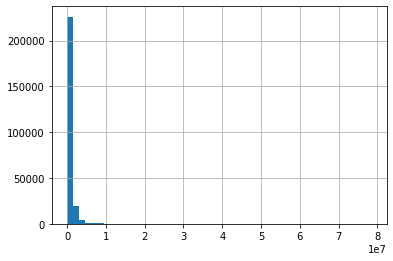

In [329]:
price_unstack_ey['price_inflated'].hist(bins=50)

In [330]:
price_unstack_ey = price_unstack_ey[price_unstack_ey['price_inflated'] < price_unstack['price_inflated'].quantile(q=0.9999)]
price_unstack_ey = price_unstack_ey[price_unstack_ey['price_inflated'] > price_unstack['price_inflated'].quantile(q=0.0005)]

[2.18759857 2.18856756 2.18875089 ... 2.18957273 2.18878833 2.18997229]


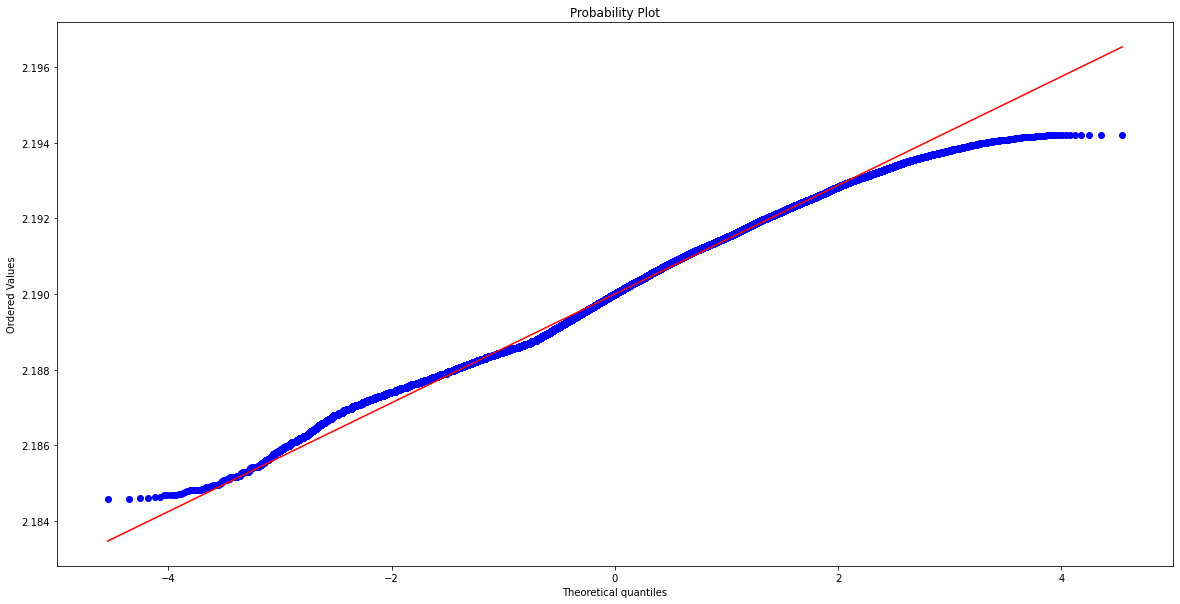

In [331]:
price_unstack_ey['y'], lamb = boxcox(price_unstack_ey['price_inflated'])

In [332]:
price_unstack_ey = price_unstack_ey.reset_index()

In [333]:
price_unstack_ey

,index,area,pay,confidence,before_after,is_new,to_construct,price_inflated,River,Central,Other,before_after x River,before_after x Central,before_after x Other,to_construct x Central,to_construct x River,to_construct x Other,Is_Flat,y
0,0,Greenwich,192.112500,7.112500,0,1,-737,254040.000000,1,0,0,0,0,0,0,-737,0,0,2.187599
1,1,Lewisham,195.250000,6.912500,0,1,-775,343100.000000,0,0,1,0,0,0,0,0,-775,1,2.188568
2,2,Croydon,193.552500,5.712500,0,1,-801,364970.800000,0,0,1,0,0,0,0,0,-801,0,2.188751
3,3,Merton,232.785714,7.457143,0,1,-779,467200.000000,0,0,1,0,0,0,0,0,-779,0,2.189434
4,4,Lambeth,204.187500,6.400000,0,1,-558,430700.000000,0,0,1,0,0,0,0,0,-558,0,2.189217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252266,267687,Lewisham,240.545000,6.012500,1,1,3365,707562.600547,0,0,1,0,0,1,0,0,3365,0,2.190423
252267,267688,Greenwich,236.168750,6.162500,1,1,3378,718424.622973,1,0,0,1,0,0,0,3378,0,0,2.190455
252268,267689,Lewisham,240.545000,6.012500,1,1,3390,492973.943004,0,0,1,0,0,1,0,0,3390,0,2.189573
252269,267690,Greenwich,236.168750,6.162500,1,1,3393,369686.769969,1,0,0,1,0,0,0,3393,0,0,2.188788


In [349]:
## Big Model 1: before_after
y = price_unstack_ey['y'].values
X = price_unstack_ey[['before_after', 'is_new', 'Is_Flat', 'River', 
                                'Central', 'before_after x River', 'before_after x Central']].values
X = np.hstack((X, np.ones((X.shape[0], 1))))    # add constant
# fit and print summary
res = sm.OLS(y, X).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                 1.376e+04
Date:                Sun, 19 Jul 2020   Prob (F-statistic):               0.00
Time:                        05:23:54   Log-Likelihood:             1.3329e+06
No. Observations:              252271   AIC:                        -2.666e+06
Df Residuals:                  252263   BIC:                        -2.666e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0008   6.91e-06    111.655      0.0

In [344]:
## Big Model 2: to_construct
y = price_unstack_ey['y'].values
X = price_unstack_ey[['pay', 'confidence', 'to_construct', 'is_new', 'Is_Flat', 'River', 
                                'Central', 'to_construct x River', 'to_construct x Central']].values
X = np.hstack((X, np.ones((X.shape[0], 1))))    # add constant
# fit and print summary
res = sm.OLS(y, X).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                 2.039e+04
Date:                Sun, 19 Jul 2020   Prob (F-statistic):               0.00
Time:                        05:21:00   Log-Likelihood:             1.3611e+06
No. Observations:              252271   AIC:                        -2.722e+06
Df Residuals:                  252261   BIC:                        -2.722e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          9.688e-06   1.13e-07     85.819      0.0

In [336]:
def reverse(res_c, bc_lambda_c):
    print((res_c.params[-1] * bc_lambda_c + 1) ** (1 / bc_lambda_c))
    return ((res_c.params+res_c.params[-1]) * bc_lambda_c + 1) ** (1 / bc_lambda_c) - ((res_c.params[-1]) * bc_lambda_c + 1) ** (1 / bc_lambda_c)

In [337]:
reverse(res, lamb)

177515.4684460919


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

invalid value encountered in power



array([ 4.24131423e+02,  1.05418295e+04,  1.42194268e+01, -1.08154744e+04,
       -3.70855914e+04, -3.10762162e+04,  1.96091865e+04, -4.97987083e-01,
       -3.18897691e+00,             nan])

In [345]:
## Submodel1: Other
y = price_unstack_ey['y']
X = price_unstack_ey[['to_construct', 'Other', 'to_construct x Other']].values
X = np.hstack((X, np.ones((X.shape[0], 1))))    # add constant
# fit and print summary
res = sm.OLS(y, X).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                 1.037e+04
Date:                Sun, 19 Jul 2020   Prob (F-statistic):               0.00
Time:                        05:21:48   Log-Likelihood:             1.3068e+06
No. Observations:              252271   AIC:                        -2.614e+06
Df Residuals:                  252267   BIC:                        -2.614e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          3.843e-07   3.29e-09    116.888      0.0

In [346]:
## Submodel2: Central
y = price_unstack_ey['y']
X = price_unstack_ey[['to_construct','Central', 'to_construct x Central']].values
X = np.hstack((X, np.ones((X.shape[0], 1))))    # add constant
# fit and print summary
res = sm.OLS(y, X).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                 2.256e+04
Date:                Sun, 19 Jul 2020   Prob (F-statistic):               0.00
Time:                        05:21:52   Log-Likelihood:             1.3221e+06
No. Observations:              252271   AIC:                        -2.644e+06
Df Residuals:                  252267   BIC:                        -2.644e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          3.681e-07   2.16e-09    170.499      0.0

In [347]:
## Submodel3: River
y = price_unstack_ey['y']
X = price_unstack_ey[['to_construct','River', 'to_construct x River']].values
X = np.hstack((X, np.ones((X.shape[0], 1))))    # add constant
# fit and print summary
res = sm.OLS(y, X).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                 2.673e+04
Date:                Sun, 19 Jul 2020   Prob (F-statistic):               0.00
Time:                        05:21:54   Log-Likelihood:             1.3269e+06
No. Observations:              252271   AIC:                        -2.654e+06
Df Residuals:                  252267   BIC:                        -2.654e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          3.273e-07   2.18e-09    149.799      0.0

In [341]:
def zone(x):
    if x in host_boroughs:
        return "River Zone"
    elif x in central_host_boroughs:
        return "Central Zone"
    elif x in other_borough:
        return "Other"

In [342]:
price_unstack_ey['zone'] = price_unstack_ey['area'].apply(zone)
# price_unstack_ey

In [343]:
import plotly.express as px
fig = px.line(price_unstack_ey, x='date', y='price_inflated', color="zone", line_group="area", template="xgridoff")

fig.update_layout(title="London Real Estate Price Trend by Olympic Zones", xaxis_title="DATE", yaxis_title="Price Inflation Adjusted")

fig.show()

ValueError: ignored

In [ ]:
X = price_unstack_england[['before_after', 'if_host', 'if_host x before_after']].values
X = np.hstack((X, np.ones((X.shape[0], 1))))    # add constant
# fit and print summary
res = sm.OLS(price_unstack_england['price_inflated'].pct_change()[1:].values, X[1:, ]).fit()
print(res.summary())

## 4.3 Two Models: one before, one after



In [ ]:
price_unstack_ey_before = price_unstack_ey[price_unstack_ey['date'] < pd.to_datetime('2007-07-01')]
price_unstack_ey_after = price_unstack_ey[price_unstack_ey['date'] >= pd.to_datetime('2007-07-01')]

In [ ]:
print(price_unstack_ey_before.shape)
print(price_unstack_ey_after.shape)

before

In [ ]:
price_unstack_ey_before['y'] = boxcox(price_unstack_ey_before['price_inflated'])

In [ ]:
y = price_unstack_ey_before['y']
X = price_unstack_ey_before[['River', 'Central']].values
X = np.hstack((X, np.ones((X.shape[0], 1))))    # add constant
# fit and print summary
res = sm.OLS(y, X).fit()
print(res.summary())

After

In [ ]:
price_unstack_ey_after['y'] = boxcox(price_unstack_ey_after['price_inflated'])

In [ ]:
y = price_unstack_ey_after['y']
X = price_unstack_ey_after[['River', 'Central']].values
X = np.hstack((X, np.ones((X.shape[0], 1))))    # add constant
# fit and print summary
res = sm.OLS(y, X).fit()
print(res.summary())